# Introduction to cBioPortal REST API

This [Jupyter notebook](https://jupyter.org/) gives examples on how to use the [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) web service from [cBioPortal](https://www.cbioportal.org) as well as other webservices from the [Knowledge Systems Group at MSKCC](https://www.mskcc.org/research-areas/labs/nikolaus-schultz). We will pull data from those APIs to make visualizations.

## How to run the notebook

This notebook can be executed on your own machine after installing Jupyter. Please install the Python 3 version of anaconda: https://www.anaconda.com/download/. After having that set up you can install Jupyter with:

```bash
conda install jupyter

```

For these examples we also require the [Swagger API](https://swagger.io/specification/) client `bravado`.

```bash
conda install -c conda-forge bravado
```

And the popular data analysis libraries pandas, matplotlib and seaborn:

```
conda install pandas matplotlib seaborn
```

Then clone this repo:

```
git clone https://github.com/cbioportal/workbench
```

And run Jupyter in this folder
```
cd workbench/intro
jupyter notebook
```
That should open Jupyter in a new browser window and you should be able to open this notebook using the web interface. You can then follow along with the next steps.

## How to use the notebook

The notebook consists of cells which can be executed by clicking on one and pressing shift+f. In the toolbar at the top there is a dropdown which indicates what type of cell you have selected e.g. `Code` or [Markdown](https://en.wikipedia.org/wiki/Markdown). The former will be executed as raw Python code the latter is a markup language and will be run through a Markdown parser. Both generate HTML that will be printed directly to the notebook page.

There a few keyboard shortcuts that are good to know. That is: `b` creates a new cell below the one you've selected and `a` above the one you selected. Editing a cell can be done with a single click for a code cell and a double click for a Markdown cell. A complete list of all keyboard shortcuts can be found by pressing the keyboard icon in the toolbar at the top.

 Give it a shot by editing one of the cells and pressing shift+f.

## Using the REST APIs

All [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) web services from the [Knowledge Systems Group](https://www.mskcc.org/research-areas/labs/nikolaus-schultz) we will be using in this tutorial have their REST APIs defined following the [Open API / Swagger specification](https://swagger.io/specification/). This allows us to use `bravado` to connect to them directly, and explore the API interactively.

For example this is how to connect to the [cBioPortal](https://www.cbioportal.org) API:

In [1]:
# from bravado.client import SwaggerClient

# cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/api-docs',
#                                 config={"validate_requests":False,"validate_responses":False})
# print(cbioportal)


SwaggerClient(https://www.cbioportal.org/api)


In [37]:
from bravado.client import SwaggerClient
import matplotlib.pyplot as plt
def get_client():
    return SwaggerClient.from_url('https://www.cbioportal.org/api/api-docs',
                                    config={"validate_requests":True,"validate_responses":False})

cbioportal = get_client()

In [38]:
# Get entity mapping
entity_study_mapping = []
study_ids = []
studies = cbioportal.Studies.getAllStudiesUsingGET(keyword='tcga_pan_can_atlas_2018', sortBy='name').result()
for study in studies:
    study_id = study.studyId 
    samples = cbioportal.Samples.getAllSamplesInStudyUsingGET(studyId=study_id).result()
    for sample in samples:
        sample_id = sample.sampleId
        entity_study_mapping.append({'entityId': sample_id, 'studyId': study_id})

In [39]:

payload = {
    'attributeIds': ["MSI_SCORE_MANTIS"],
    'identifiers': entity_study_mapping
}

RES_MSI_SCORE_MANTIS = cbioportal.Clinical_Data.fetchClinicalDataUsingPOST(clinicalDataMultiStudyFilter=payload).result()

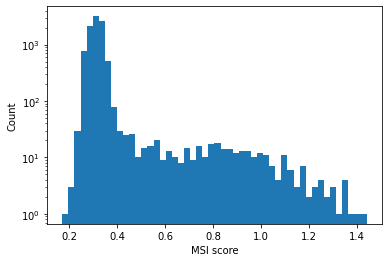

In [40]:
vals = [float(x.value) for x in RES_MSI_SCORE_MANTIS]
plt.hist(vals, bins=50, log=True)
plt.xlabel("MSI score")
plt.ylabel("Count")
plt.show()

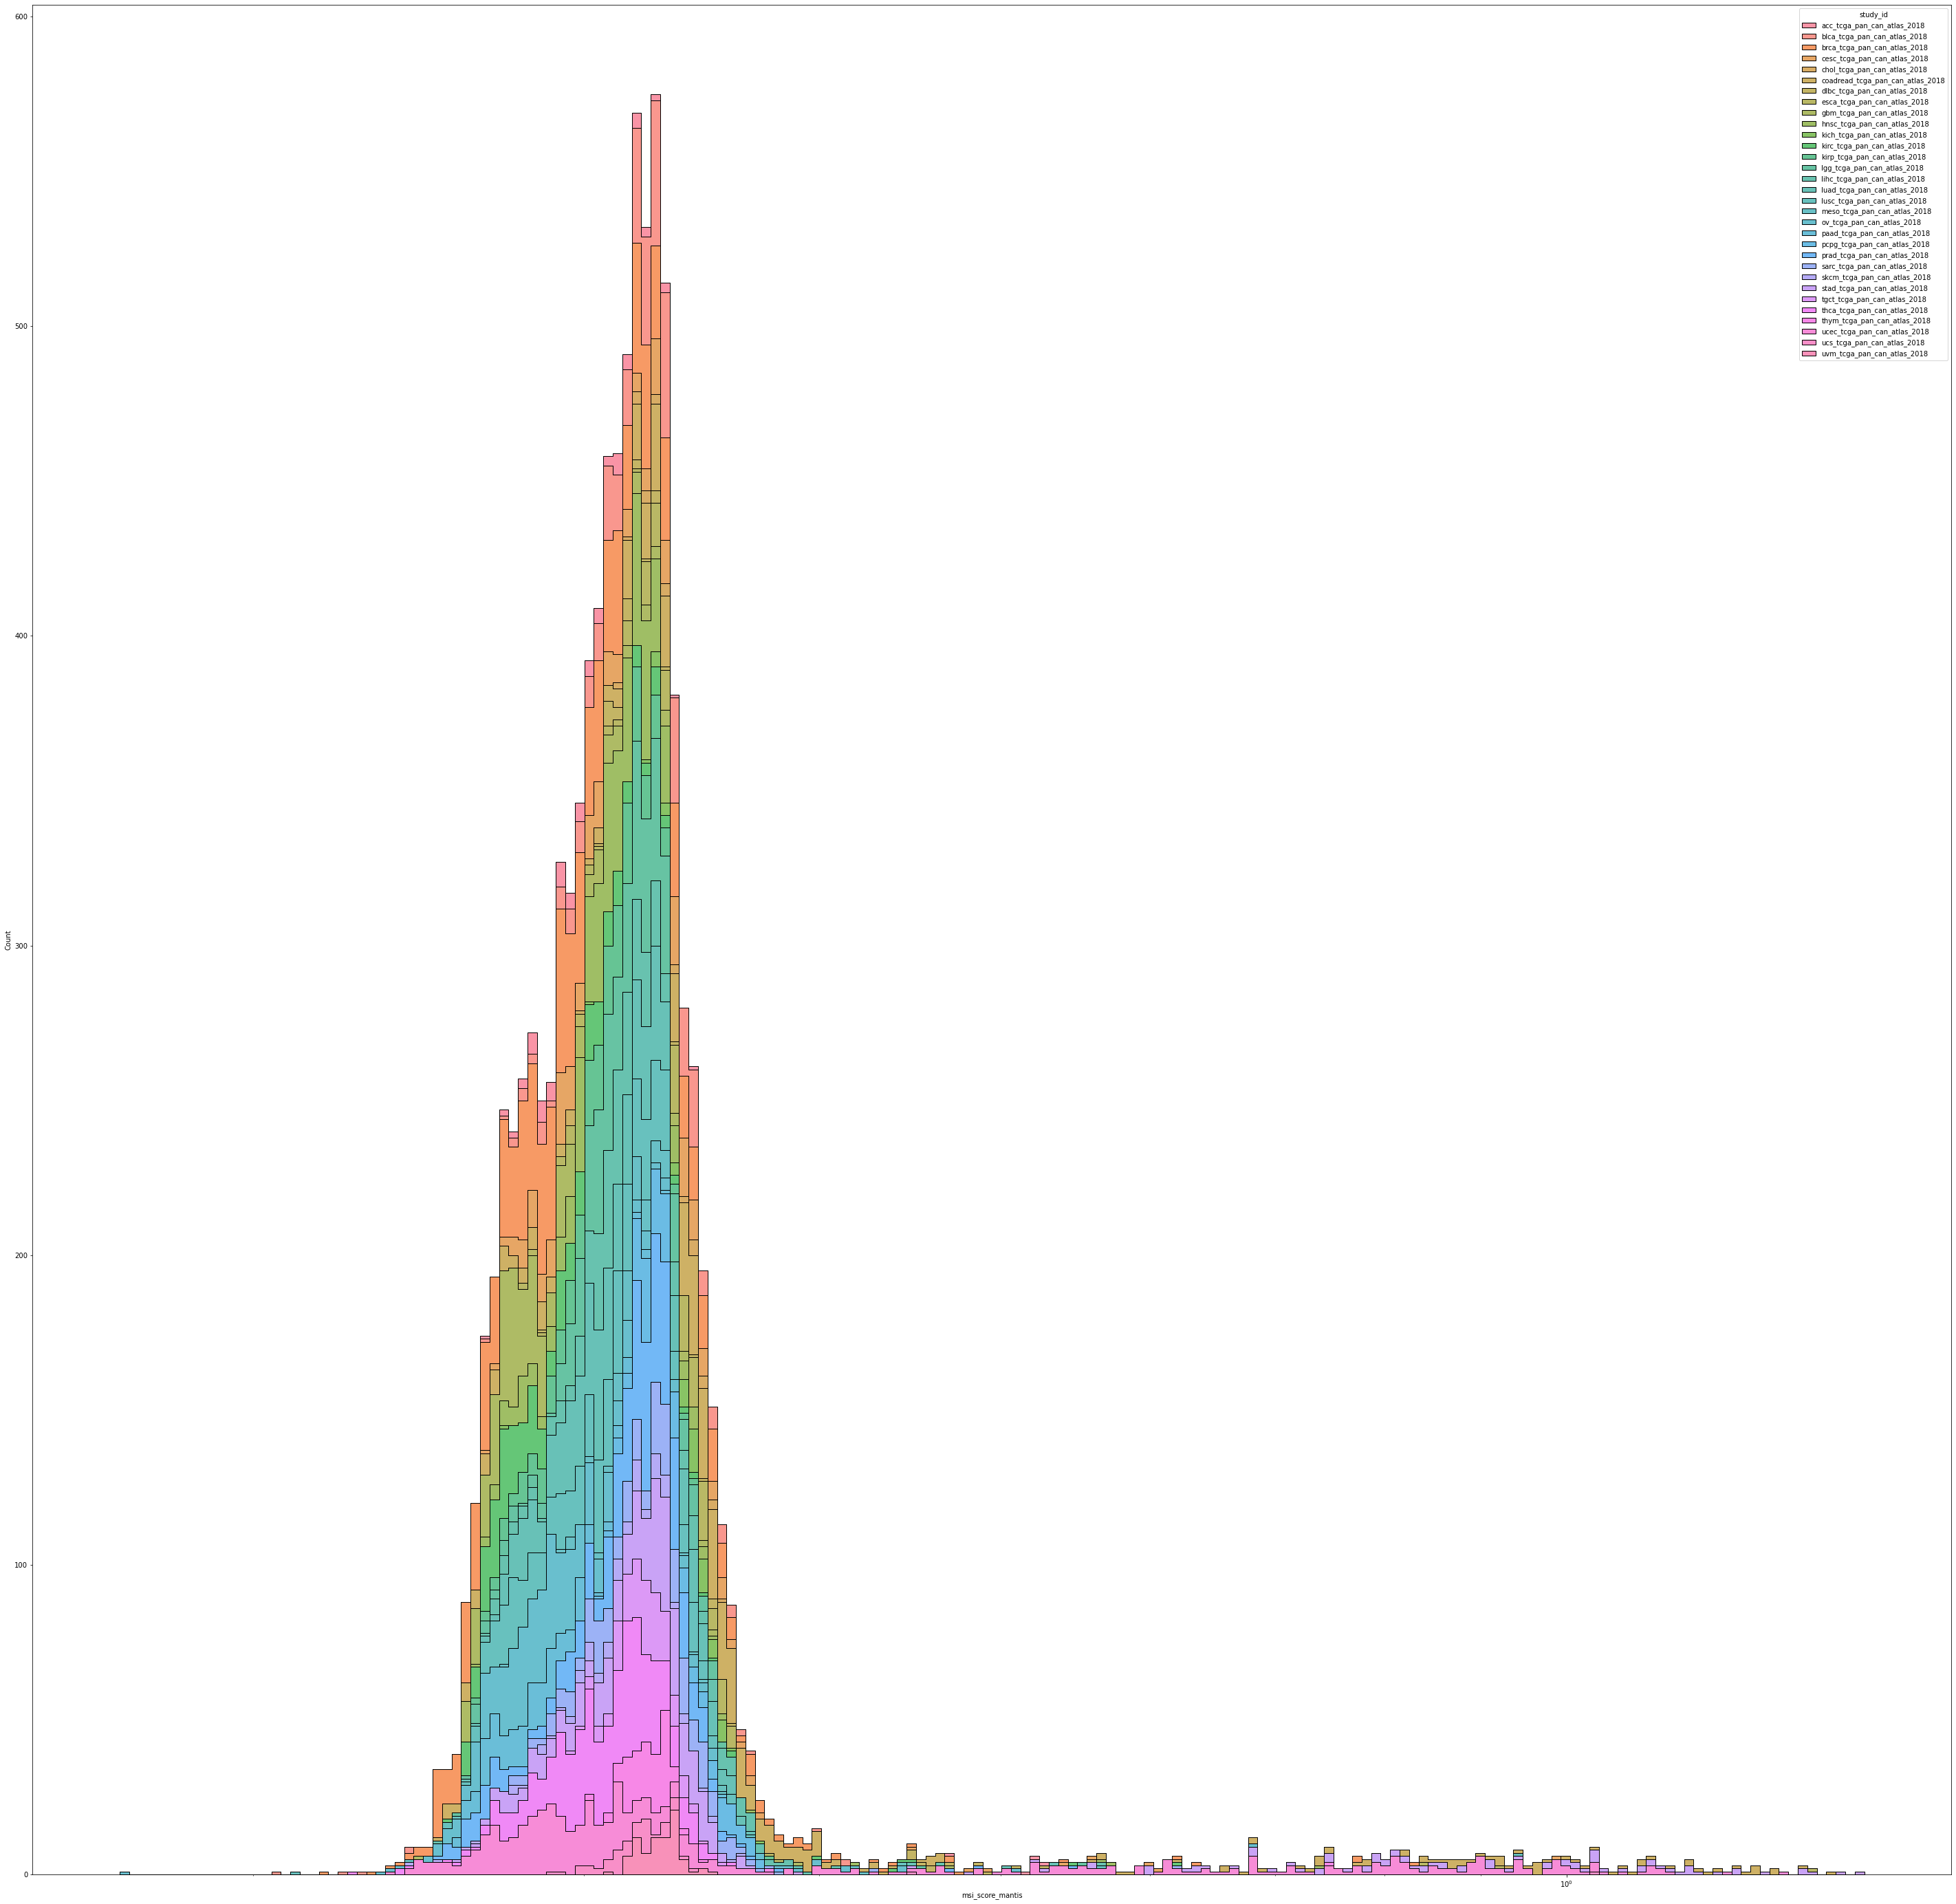

In [68]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot



data = [[x.patientId, x.studyId, float(x.value)] for x in RES_MSI_SCORE_MANTIS]

df = pd.DataFrame(data, columns=['patient_id', 'study_id', 'msi_score_mantis'])




fig, ax = pyplot.subplots(figsize=(50,50))
sns.histplot(data=df, x="msi_score_mantis", hue="study_id", element="step",multiple="stack",log_scale=True)



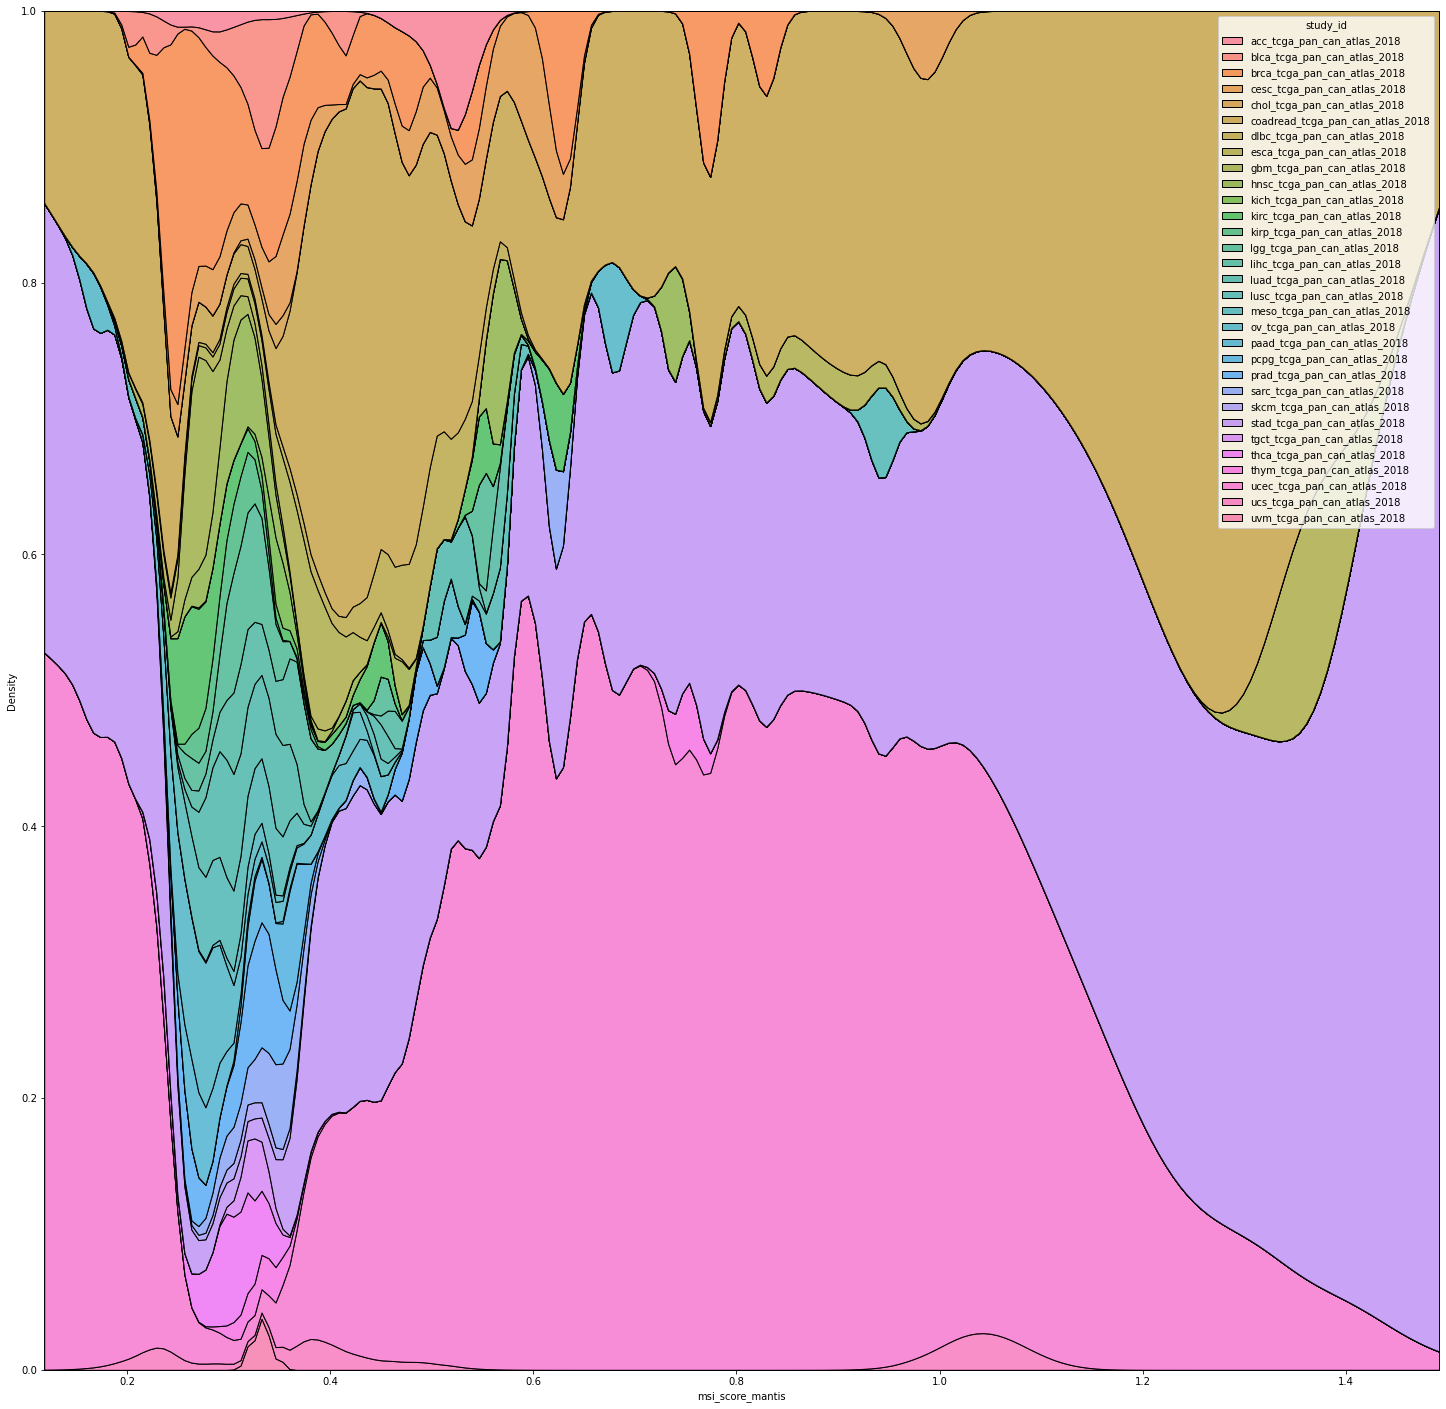

In [79]:

fig, ax = pyplot.subplots(figsize=(25,25))
# sns.histplot(data=df, x="msi_score_mantis", hue="study_id", element="step",multiple="stack",log_scale=True,kde=True)
sns.kdeplot(data=df, x="msi_score_mantis", hue="study_id", common_norm=True,  multiple="fill")


In [83]:
payload = {
    'attributeIds': ["FRACTION_GENOME_ALTERED"],
    'identifiers': entity_study_mapping
}
RES_FRACTION_GENOME_ALTERED = cbioportal.Clinical_Data.fetchClinicalDataUsingPOST(clinicalDataMultiStudyFilter=payload).result()
fga_list = [[x.patientId, x.studyId, float(x.value)] for x in RES_FRACTION_GENOME_ALTERED]


df_fga = pd.DataFrame(fga_list, columns=['patient_id', 'study_id', 'fraction_genome_altered'])




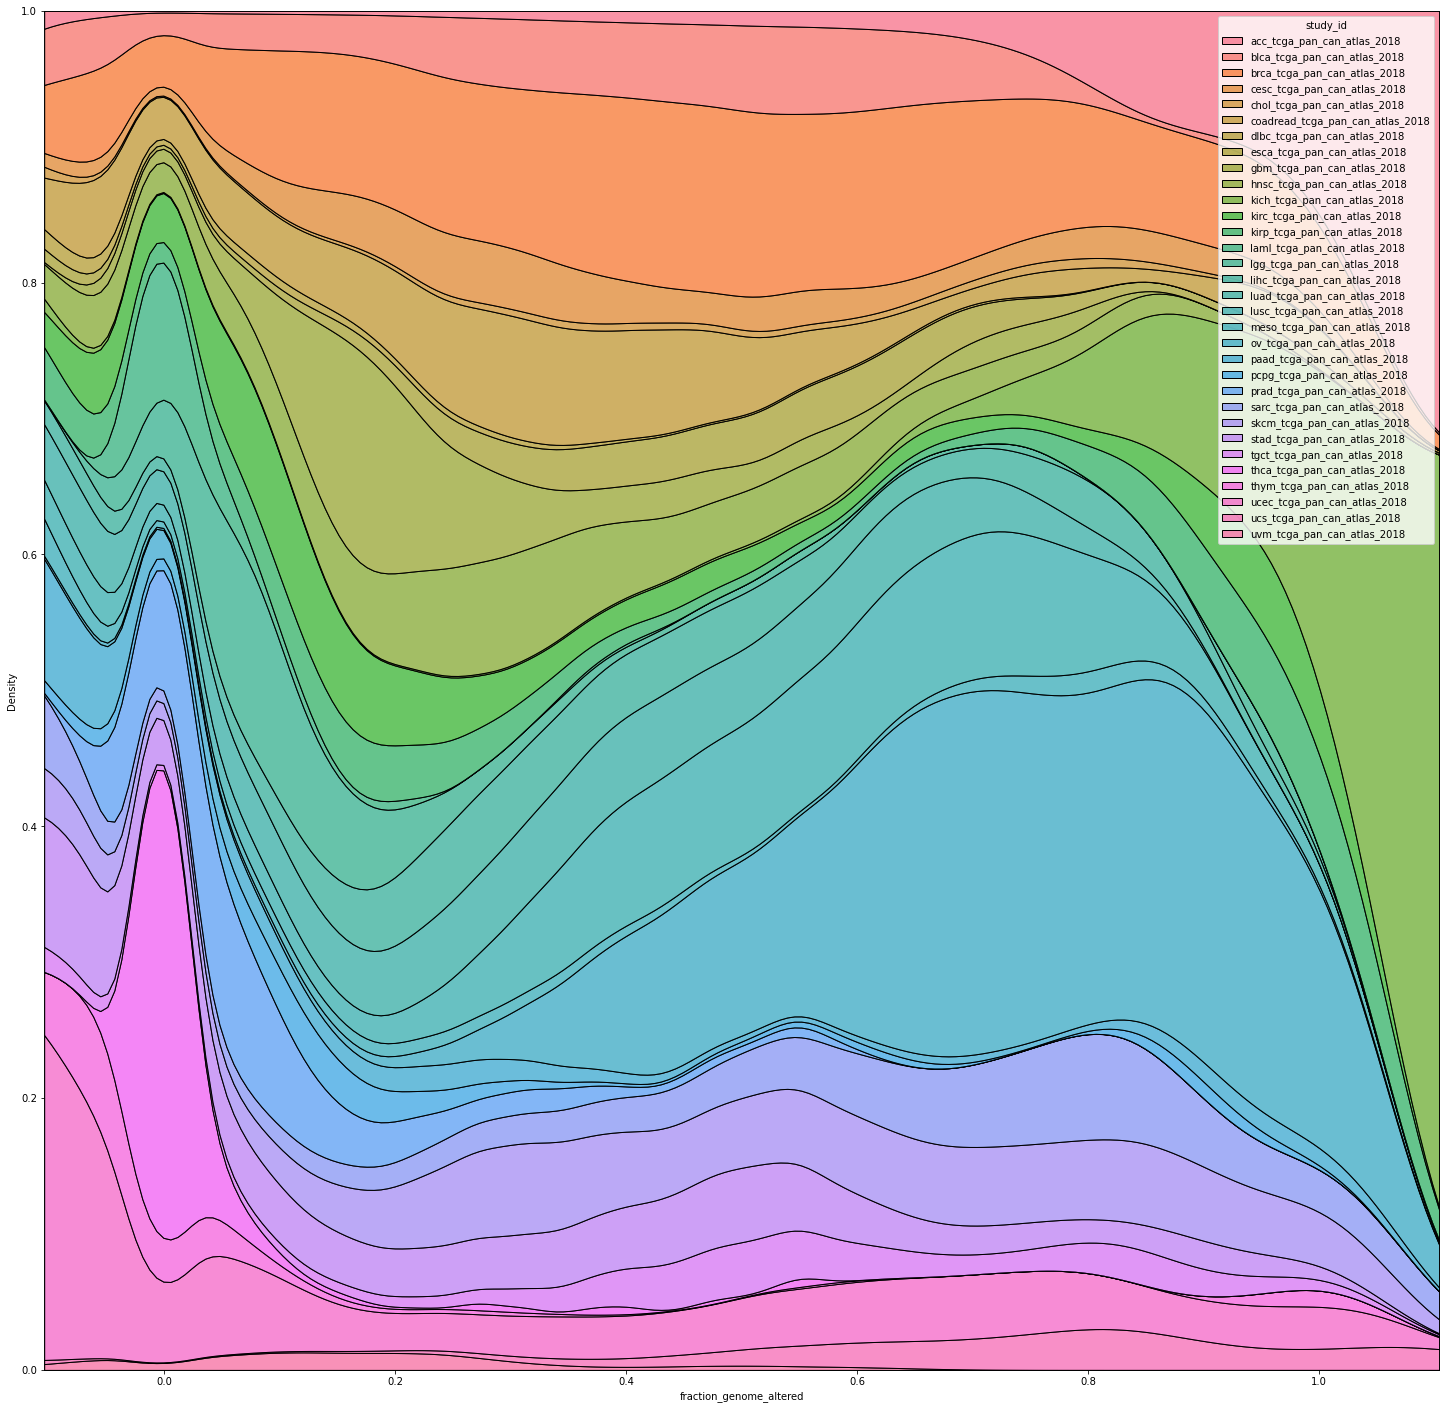

In [84]:

fig, ax = pyplot.subplots(figsize=(25,25))
# sns.histplot(data=df, x="msi_score_mantis", hue="study_id", element="step",multiple="stack",log_scale=True,kde=True)
sns.kdeplot(data=df_fga, x="fraction_genome_altered", hue="study_id", common_norm=True,  multiple="fill")


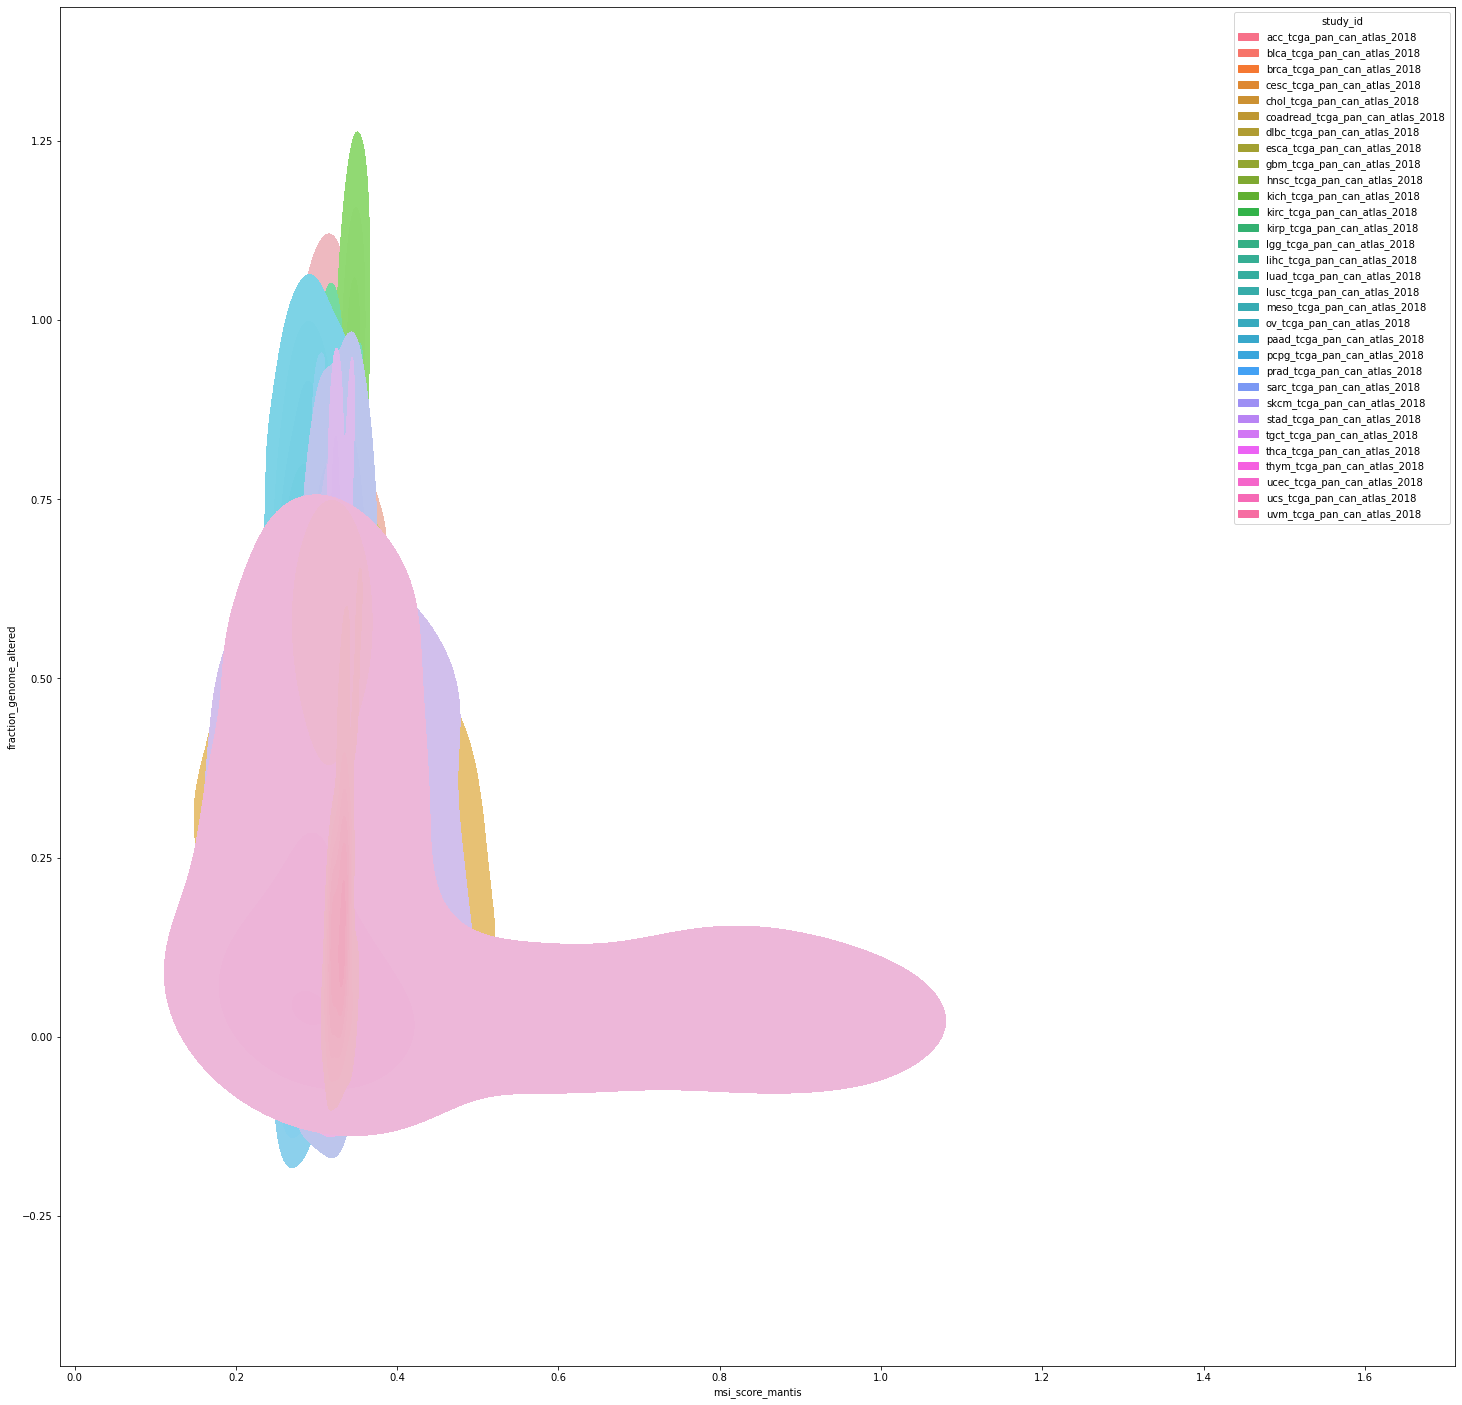

In [99]:
joined_df = pd.merge(df, df_fga, on=['patient_id', 'study_id'])


fig, ax = pyplot.subplots(figsize=(25,25))
sns.kdeplot(data=joined_df, x="msi_score_mantis", y="fraction_genome_altered", hue="study_id",fill=True)

# joined_df.to_csv("fraction_genome_altered_MSI_tcga_pancan.csv")